In [4]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from skimage import data
from skimage import color
from skimage.util.shape import view_as_windows
from skimage.util import view_as_blocks
from skimage.io import imread
from skimage.transform import resize
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
import seaborn as sns
# import skimage.util.montage2d
from skimage.util import montage as montage2d


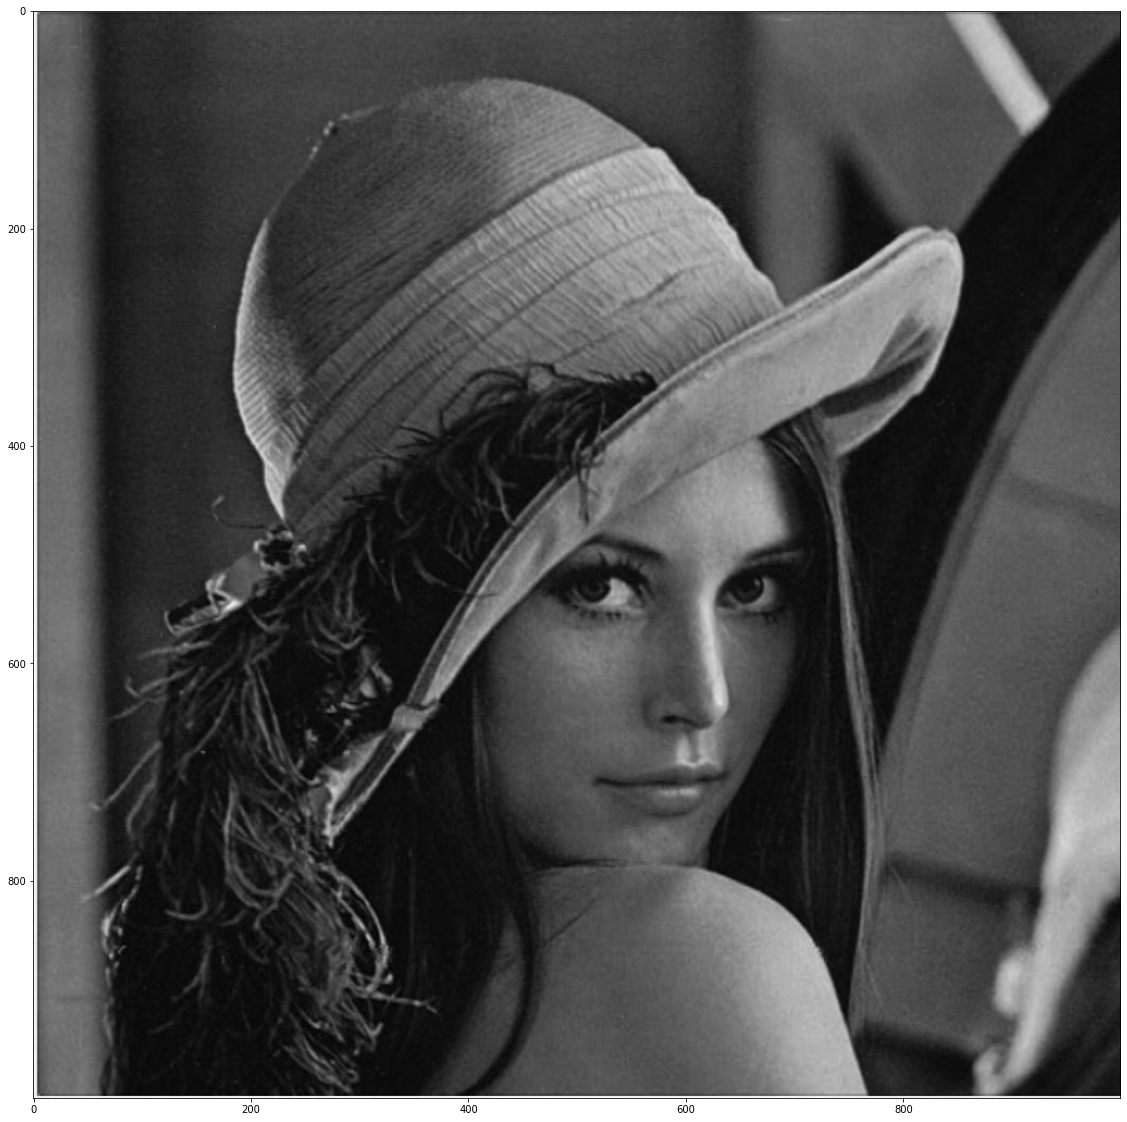

In [2]:
puzzle = imread("lena.jpg", as_gray=True) # Image name
puzzle = resize(puzzle,(1000,1000))
fig = plt.figure(figsize=(20,20))
plt.imshow(puzzle,cmap=plt.cm.gray)


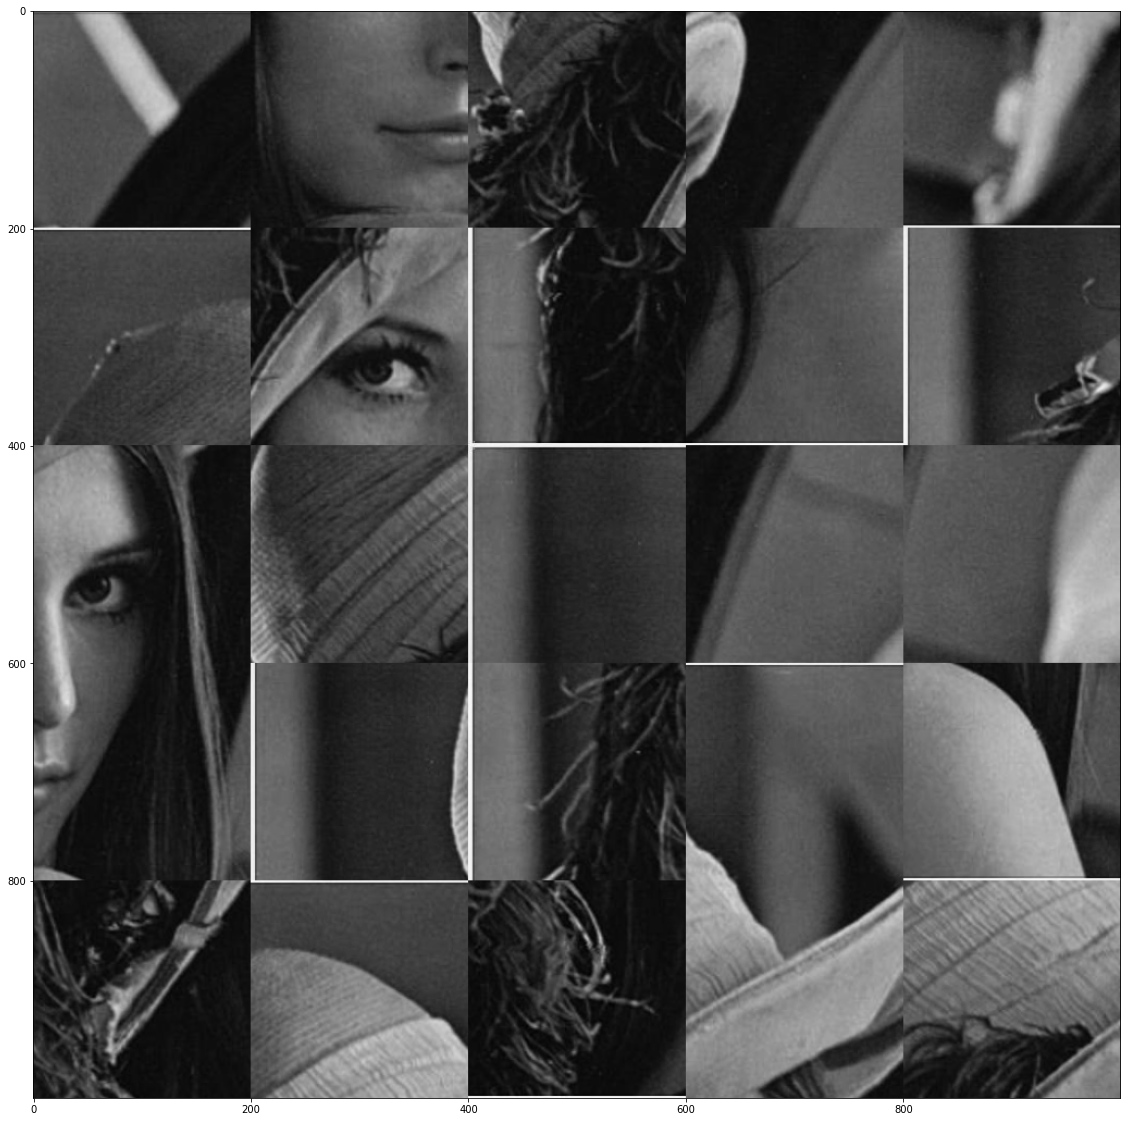

In [5]:
puzzle_shape = (200,200)
puzzle_blocks_orig = view_as_blocks(puzzle,block_shape=puzzle_shape)

puzzle_blocks = puzzle_blocks_orig
puzzle_blocks = puzzle_blocks.reshape((-1,) + puzzle_shape)

np.random.shuffle(puzzle_blocks)
puzzle_montage = montage2d(puzzle_blocks)

fig = plt.figure(figsize=(20,20))
plt.imshow(puzzle_montage,cmap='gray')

In [6]:
from sklearn.metrics.pairwise import pairwise_distances
from skimage.util import view_as_blocks
from sklearn.feature_extraction.image import extract_patches_2d
bw = 1
orientations = ['bottom','top','left','right']
top_ = lambda X,bw: X[0:bw,:].reshape(1,-1)
right_ = lambda X,bw: X[:,0:bw].reshape(1,-1)
bottom_ = lambda X,bw: X[(-1-bw):-1, :].reshape(1,-1)
left_ = lambda X,bw:  X[:, (-1-bw):-1].reshape(1,-1)

def edge_distances(A,B):
  bw = 1
  d1 = pairwise_distances( top_(A,bw), bottom_(B,bw),metric ="cosine")[0][0]
  d2 = pairwise_distances( bottom_(A,bw), top_(B,bw),metric ="cosine")[0][0]
  d3 = pairwise_distances( right_(A,bw), left_(B,bw),metric ="cosine")[0][0]
  d4 = pairwise_distances( left_(A,bw), right_(B,bw),metric ="cosine")[0][0]
  return [d1,d2,d3,d4]

def piece_dissimilarity(A,B):
  ed =edge_distances(A,B)
  return np.min(ed),np.argmin(ed)

n = puzzle_blocks.shape[0]
Ke = np.zeros((n,n))
KeO =  np.zeros((n,n))
for i in np.arange(n):
  for j in np.arange(n):
    Ke[i,j],KeO[i,j] = piece_dissimilarity(puzzle_blocks[i], puzzle_blocks[j])



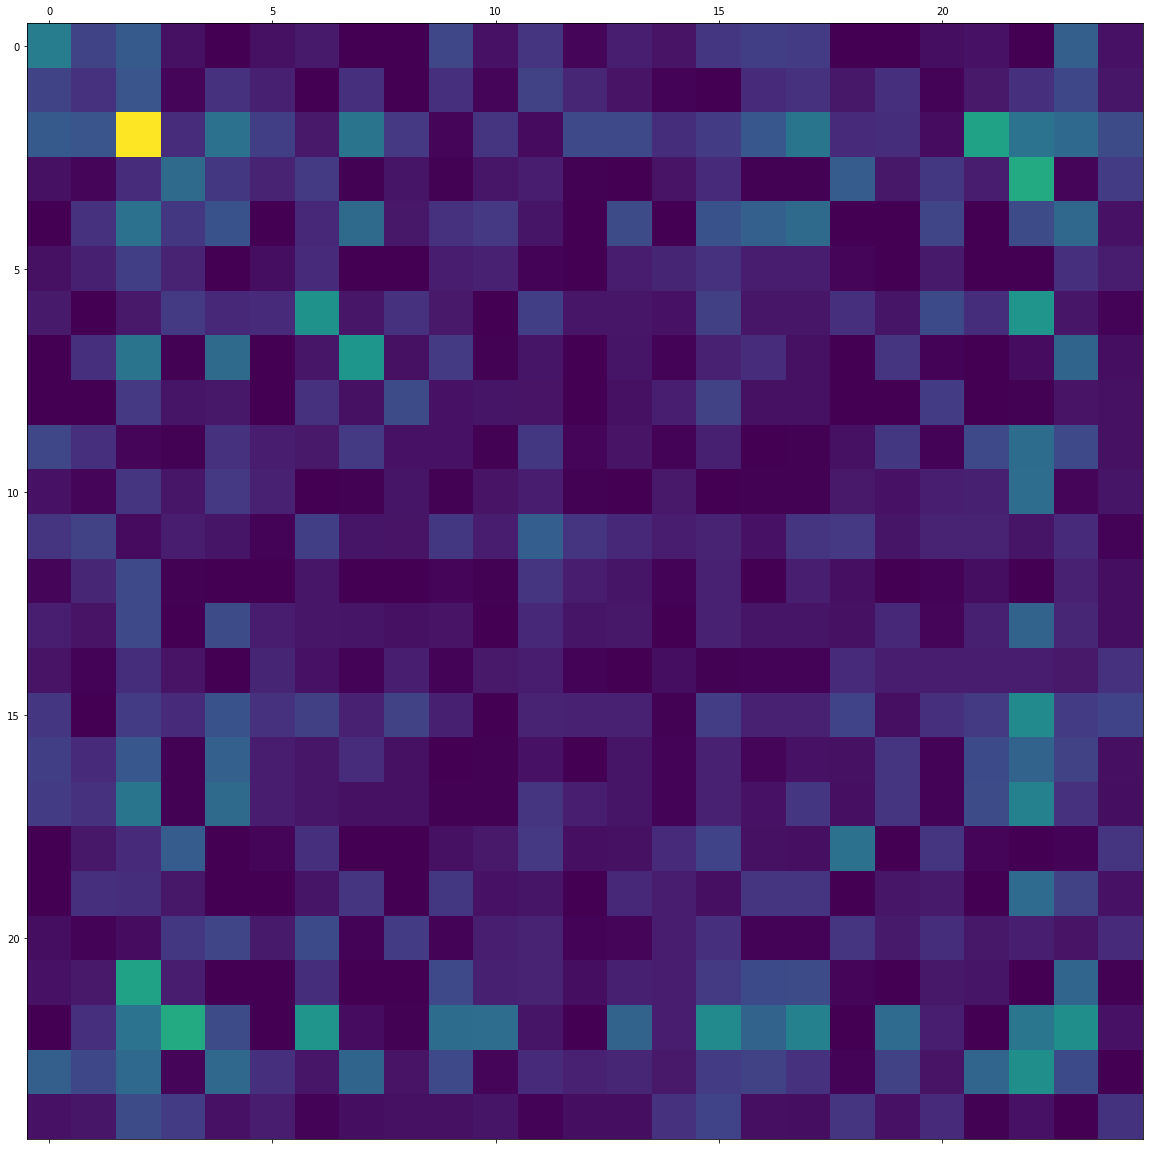

In [7]:
plt.figure(figsize=(20,20))
plt.matshow(Ke, fignum=1)

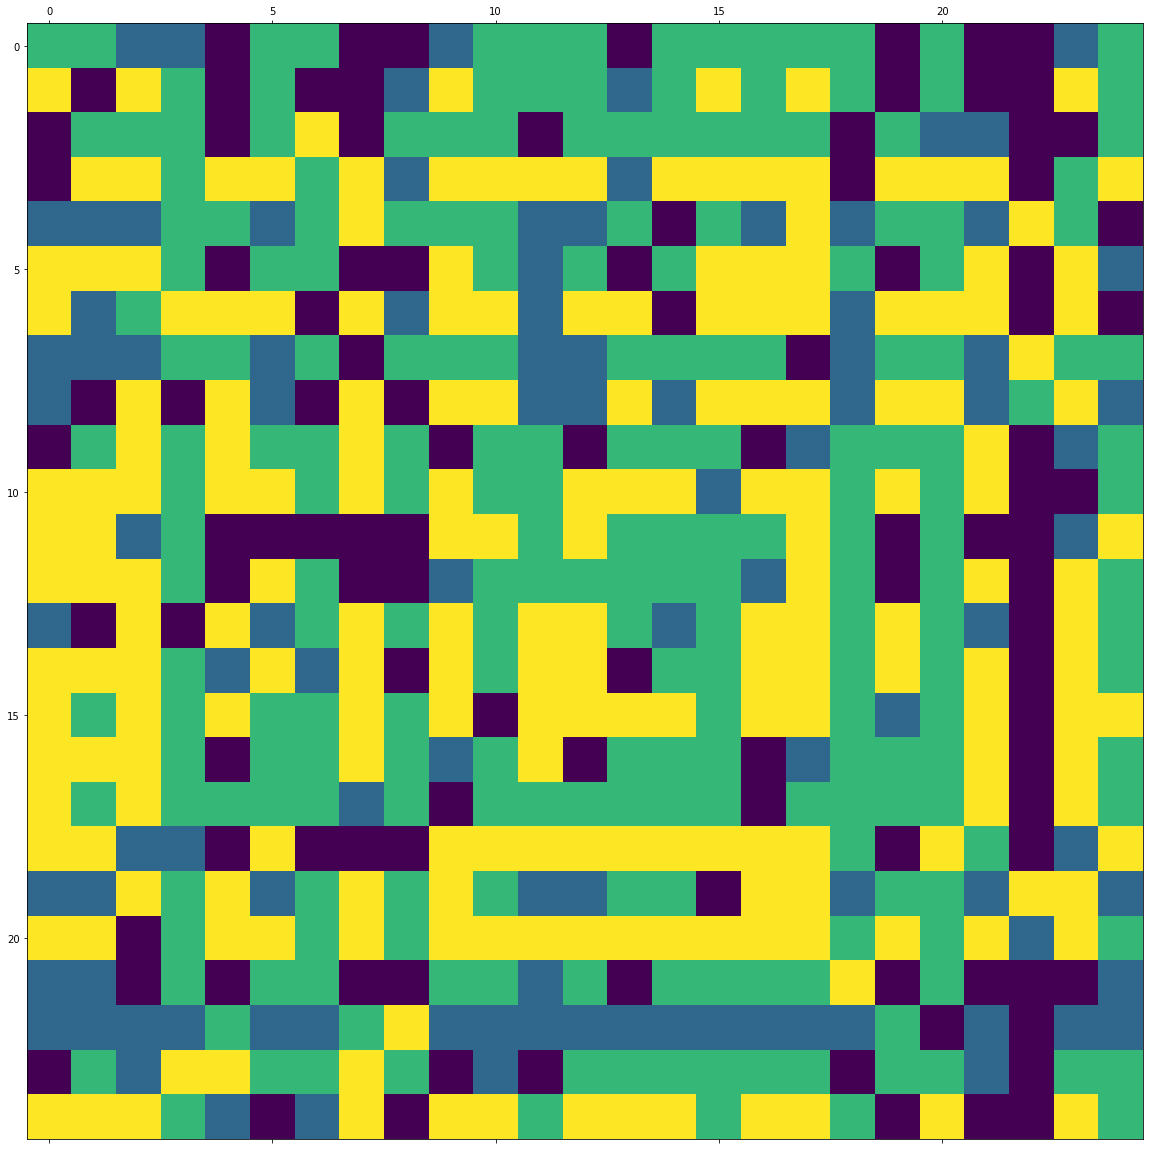

In [8]:
plt.figure(figsize=(20,20))
plt.matshow(KeO, fignum=1)

# Genetic Algorithm

In [30]:
def individual(length):
  xi =  np.arange(length)
  np.random.shuffle(xi)
  return xi.tolist()

individual(25)

[5,
 15,
 23,
 3,
 0,
 12,
 13,
 2,
 1,
 18,
 17,
 4,
 16,
 10,
 21,
 6,
 9,
 24,
 19,
 14,
 8,
 22,
 11,
 20,
 7]

## Fitness function

In [42]:
def indv_to_edgelist(individual):
  n = int(np.sqrt(len(individual)))
  A = np.array(individual).reshape(n,n)
  obs_edges= set()
  for i in np.arange(n):
    for j in np.arange(n):
      if j+1<n:
        ii = A[i,j]
        jj = A[i,j+1]
        obs_edges.add((ii,jj,KeO[ii,jj]))
      if i+1<n:
        ii = A[i,j]
        jj = A[i+1,j]
        obs_edges.add((ii,jj,KeO[ii,jj]))
  return obs_edges

def fitness(individual, target=1):
  elist = indv_to_edgelist(individual)
  return (np.sum([Ke[e[0],e[1]] for e in elist]))
  

## Intialization

In [43]:
# import functools
def population(count, length):
    return [ individual(length) for x in range(count)]
def grade(pop, target):
  summed = functools.reduce(add, (fitness(x, target) for x in pop))
  return summed/(len(pop)*1.0)
  

## cross over

In [44]:
def edge_pairs(individual):
  n = int(np.sqrt(len(individual)))
  m = n
  A = np.array(individual).reshape(n,n)
  obs_edges = set()
  for i in np.arange(n):
    for j in np.arange(n):
      if j+1 <m:
        ii = A[i,j]
        jj = A[i,j+1]
        if i < j:
          obs = (ii,jj, 3.0, ((i,j),(i,j+1)))
        else:
          obs = (ii,jj, 2.0, ((i,j),(i,j+1)))
        obs_edges.add(obs)
      if i+1 < n:
        ii = A[i,j]
        jj = A[i+1, j]
        if i <j:
          obs = (ii,jj, 0.0, ((i,j),(i+1,j)))
        else:
          obs = (ii, jj, 1.0, ((i,j),(i+1,j)))
        obs_edges.add(obs)
  return list(obs_edges)

def update_boundary(child):
  n = int(np.sqrt(child.shape[0]))
  Cmat =  child.reshape(n,n)
  candidate_pairs = edge_pairs(child)
  candidate_pairs = [c for c in candidate_pairs if (c[0]==-1) != (c[1]==-1)]

  results = []
  for cix in candidate_pairs:
    a = cix[0]
    b = cix[1]
    o = cix[2]
    ref = np.max([a,b])
    n_neighbours = np.argsort(Ke[ref,:])
    for nn in n_neighbours:
      if  ((nn in child) ==  False) & (KeO[ref, nn] == o):
        results.append((ref, nn, o, Ke[ref, nn], cix[3], (a,b)))
        break
  if len(results)>0:
    result = sample(results,1)[0]
    if result[5][0] == -1:
      rep_value = result[1]
      xi =  int(result[4][0][0])
      yi = int(result[4][0][1])
    else:
      rep_value = result[1]
      xi = int(result[4][1][0])
      yi = int(result[4][1][1])
    Cmat[xi,yi] = rep_value
    child = Cmat.reshape(1,-1)[0]
  else:
    missing_pieces = idx_[np.isin(idx_,child)==False]
    np.random.shuffle(missing_pieces)
    missing_pieces
    iter = 0
    for i in np.arange(child.shape[0]):
      if child[i]==-1:
        child[i] = missing_pieces[iter]
        iter+=1
  return child

def crossover_operator(male, female):
  child = np.zeros(male.shape[0]).astype(int)
  child[:] = 1
  
  match_indices = np.where(male==female)
  child[match_indices] = female[match_indices]

  if child.sum() == -1*child.shape[0]:
    idx = np.random.choice(np.arange(child.shape[0]))
    child[idx] = male[idx]
  
  while (child.sum() < np.arange(child.shape[0]).sum()):
    child = update_boundary(child)
  return child

## Evolution cycle

In [45]:
from random import randint, random, sample
from operator import add

def evolve(pop, target,  retain = 0.2, random_select = 0.05, mutate = 0.05):
  graded  =[ (fitness(x, target),x) for x in pop]
  graded = [x[1]  for x in sorted(graded)]
  retain_length = int(len(graded)*retain)
  parents = graded[:retain_length]

  for individual in graded[retain_length:]:
    if random_select > random():
      parents.append(individual)

  for individual in parents:
    if mutate >random():
      individual = np.roll(individual, 1)
  
  parents_length = len(parents)
  desired_length = len(pop) - parents_length
  children = []

  while len(children) < desired_length:
    male = randint(0, parents_length-1)
    female = randint(0, parents_length -1 )
    if male!= female:
      male = parents[male]
      female = parents[female]
      child = crossover_operator (np.array(male), np.array(female))
      child = child.tolist()
      children.append(child)
  parents.extend(children)
  return parents
  

## Demonstration

In [47]:
n=np.sqrt(Ke.shape[0])
m=np.sqrt(Ke.shape[0])

target = 1.0
p_count = 1000
p = population(p_count,Ke.shape[0])
fitness_history =[grade(p,target),]


iteration_img=[]
for i in range(50):

  p=evolve(p,target, retain=0.4,random_select=0.05,mutate=0.01)
  fitness_iter=grade(p,target)
  fitness_history.append(fitness_iter)
  opt_index  =np.argmin([fitness(pi,0) for pi in p])
  idx = opt_index
  iter_attempt=montage2d(puzzle_blocks[p[opt_index],:,:])
  iteration_img.append(iter_attempt)
  print (fitness_iter)


NameError: name 'idx' is not defined

In [ ]:
idx = np.argmin([fitness(pi, 0) for pi in p])
attempt = montage2d(puzzle_blocks[p[idx],:,:])

In [ ]:
fig = plt.figure(figsize = (20,20))
plt.imshow(attempt, cmap = plt.cm.gray)

In [ ]:
fig = plt.figure(figsize=(20,20))
plt.plot(fitness_history)

## another image

In [ ]:
puzzle = imread("lena.jpg",as_gray=True)
puzzle = resize(puzzle,(1000,1000))

# generate puzzle
puzzle_shape = (200,200)
puzzle_blocks_orig = view_as_blocks(puzzle, block_shape = puzzle_shape)
puzzle_blocks = puzzle_blocks_orig
puzzle_blocks = puzzle_blocks.reshape((-1,) + puzzle_shape)
np.random.shuffle(puzzle_blocks)
puzzle_montage = montage2d(puzzle_blocks)

# compute pairwise dissimilarity and orientations
n = puzzle_blocks.shape[0]
ke = np.zeros((n,n))
KeO =  np.zeros((n,n))
for i in np.arange(n):
  for j in np.arange(n):
    ke[i,j], KeO[i,j] =  piece_dissimilarity(puzzle_blocks[i], puzzle_blocks[j])
  
# Evovle solution
n = np.sqrt(Ke.shape[0])
m = np.sqrt(Ke.shape[0])
target = 1.0
p_count = 10000 # population count

fitness_history = [grade(p,target)]

iteration_img = []
for i in range(100):
  p = evolve(p, target, retain=0.4, random_select = 0.05, mutate=0.01)
  fitness_iter =  grade(p, target)
  fitness_history.append(fitnees_iter)
  opt_index = idx = np.argmin([fitness(pi,0) for pi in p])
  iter_attempt = montage2d(puzzle_blocks[p[opt_index],:,:])
  iteration_img.append(iter_attempt)
  print(fitnees_iter)

idx =  argmin([fitness(pi,0) for pi in p])
attempt = montage2d(puzzle_blocks[p[idx],:,:])


In [ ]:
fig = plt.figure(figsize=(20,20))
plt.plot(fitness_history)